In [34]:
import tensorflow as tf   
import torch
print(tf.__version__)     
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Dataset
import importlib
import custom_transformers
importlib.reload(custom_transformers)
from custom_transformers import *
import warnings
warnings.filterwarnings('ignore')


2.19.0


# Cifar 10 df

In [14]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Pipelines 

In [15]:

before_cutout = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128)])

after_cutout = transforms.Compose([ 
    transforms.GaussianBlur(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Cutout transformer 1 
### without color 

In [16]:
cutout = RandomPixelCutout(max_cutout_size=0.1)

In [17]:
X_train = torch.tensor(X_train).permute(0, 3, 1, 2)  # Transforming from (batch, height, width, channels) to (batch, channels, height, width)
X_test = torch.tensor(X_test).permute(0, 3, 1, 2)
train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))  

# data loader automatycznie robi transform więc to już podajemy do uczenia modelu !!! 
train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

## Visualisations for one loaded batch

### Train set

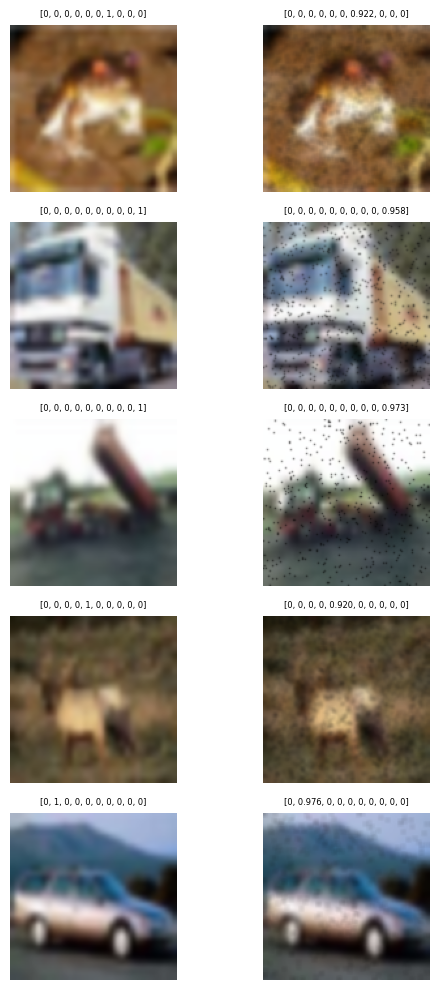

In [18]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    # Convert tensor image to displayable format
    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    
    # For soft labels (probability distributions)
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")  # Dla 0 lub 1 pokazuj jako integer
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Test set - no cutout expected

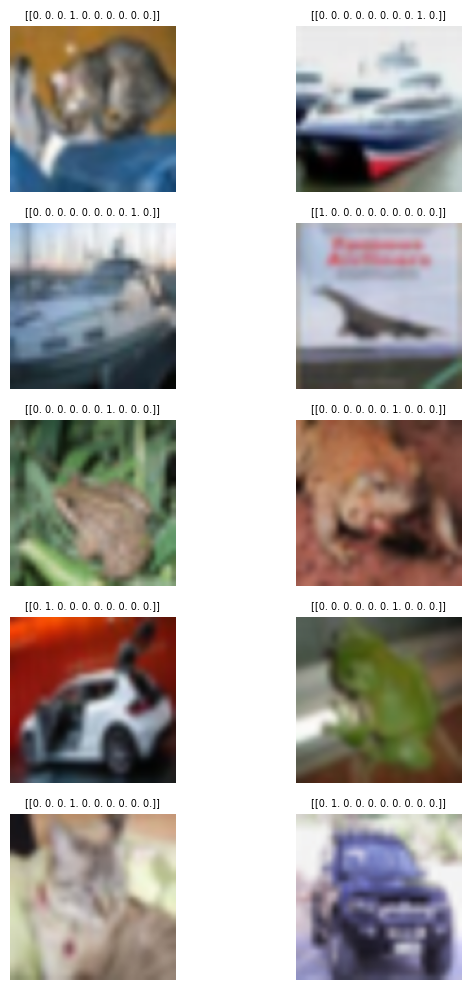

In [19]:
batch_images, batch_labels = next(iter(test_loader))

fig, axes = plt.subplots(5, 2, figsize=(7, 10))
plt.rc('axes', titlesize=7)
for i in range(10):
    row = i //2  # Dla i=0,1,2 -> row=0; i=3,4,5 -> row=1
    col = i % 2
    # Convert tensor image to displayable format
    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    
    label_probs = batch_labels[i].numpy()  
    axes[row, col].imshow(img)
    axes[row, col].set_title(label_probs)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## With selected color

In [20]:
cutout = RandomPixelCutout(max_cutout_size=0.6, color=True)
train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

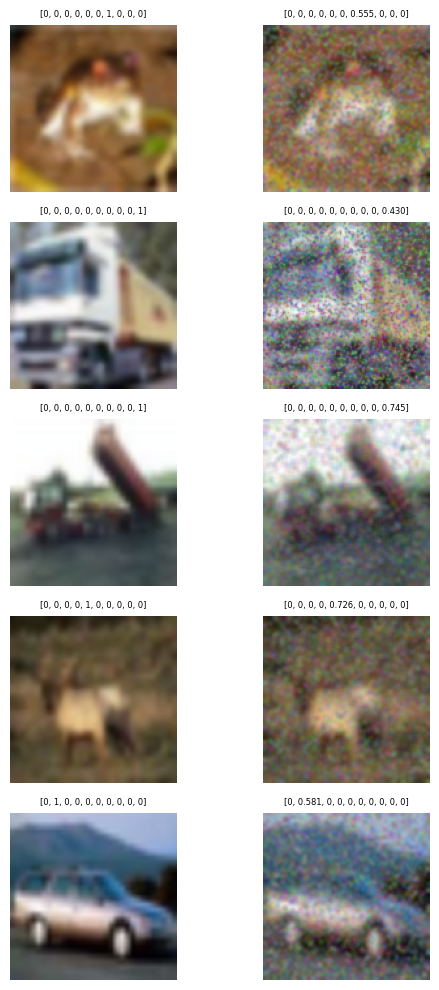

In [21]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    # Convert tensor image to displayable format
    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    
    # For soft labels (probability distributions)
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")  # Dla 0 lub 1 pokazuj jako integer
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Cutout transformer - square

In [22]:
cutout = SquareCutout(size=50)

In [23]:
# X_train = torch.tensor(X_train).permute(0, 3, 1, 2)  # Transforming from (batch, height, width, channels) to (batch, channels, height, width)
# X_test = torch.tensor(X_test).permute(0, 3, 1, 2)
train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))  

# data loader automatycznie robi transform więc to już podajemy do uczenia modelu !!! 
train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

### Smaller cutout Visualization
### without color

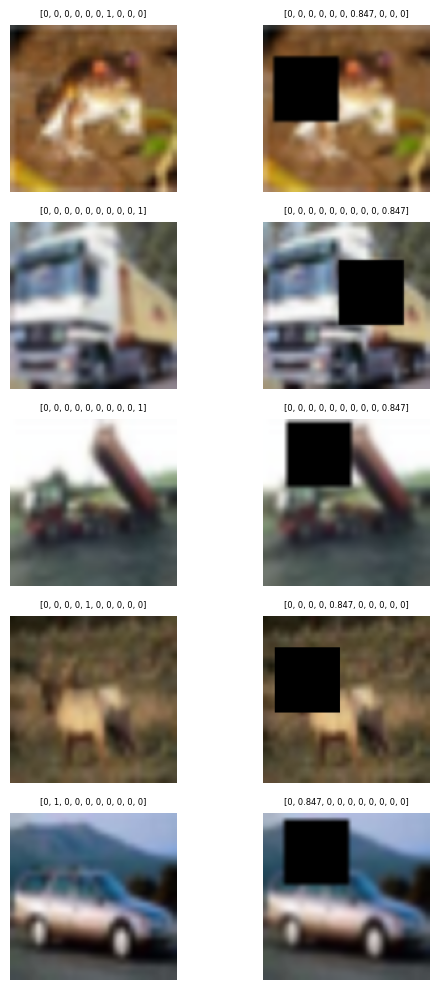

In [24]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    # Convert tensor image to displayable format
    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    
    # For soft labels (probability distributions)
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")  # Dla 0 lub 1 pokazuj jako integer
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Bigger square cutout
### with color

In [25]:
cutout_bigger = SquareCutout(size=80, color=True)
# X_train = torch.tensor(X_train).permute(0, 3, 1, 2)  # Transforming from (batch, height, width, channels) to (batch, channels, height, width)
# X_test = torch.tensor(X_test).permute(0, 3, 1, 2)
train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))  

# data loader automatycznie robi transform więc to już podajemy do uczenia modelu !!! 
train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout_bigger, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

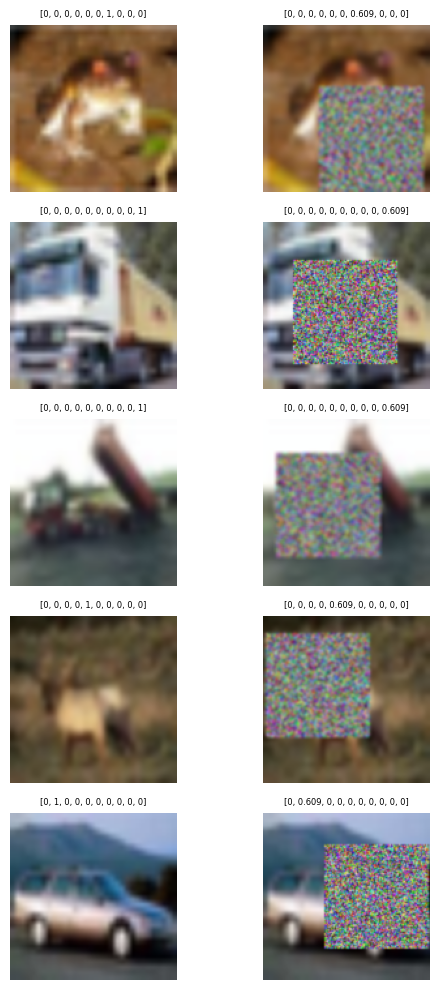

In [26]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    # Convert tensor image to displayable format
    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    
    # For soft labels (probability distributions)
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")  # Dla 0 lub 1 pokazuj jako integer
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Cutout tranformer - circle

In [35]:
cutout_circle = CircleCutout(max_size_ratio=0.3)

train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))  

train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout_circle, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

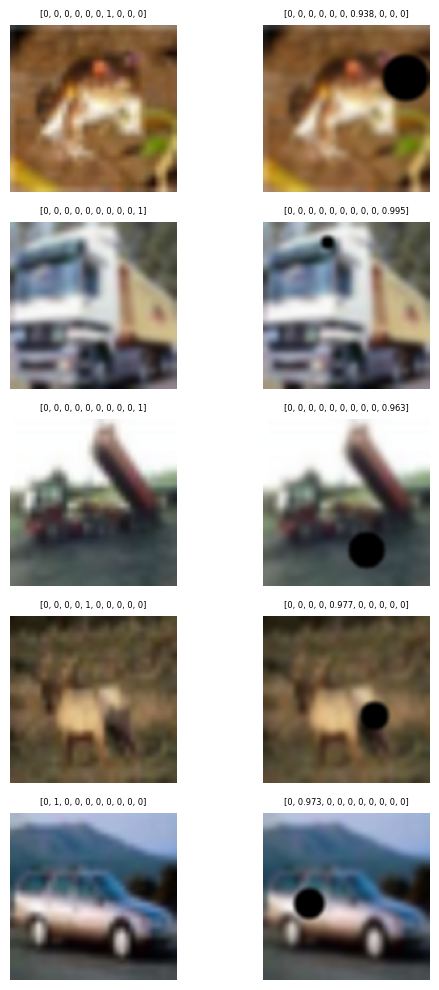

In [36]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
   
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Cutout tranformer - polygon

In [27]:
cutout_polygon = PolygonCutout(max_size_ratio=0.3, max_vertices=12, min_vertices=8)

train_dataset = torch.utils.data.TensorDataset(X_train, torch.tensor(Y_train))
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(Y_test))  

train_loader = DataLoader(SoftLabelDataset(dataset = train_dataset, pipeline_before_cutout = before_cutout, cutout_transform =cutout_polygon, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)
test_loader = DataLoader(SoftLabelDataset(dataset = test_dataset, pipeline_before_cutout = before_cutout, cutout_transform =None, pipeline_after_cutout = after_cutout, num_classes= 10), batch_size=32, shuffle=False)

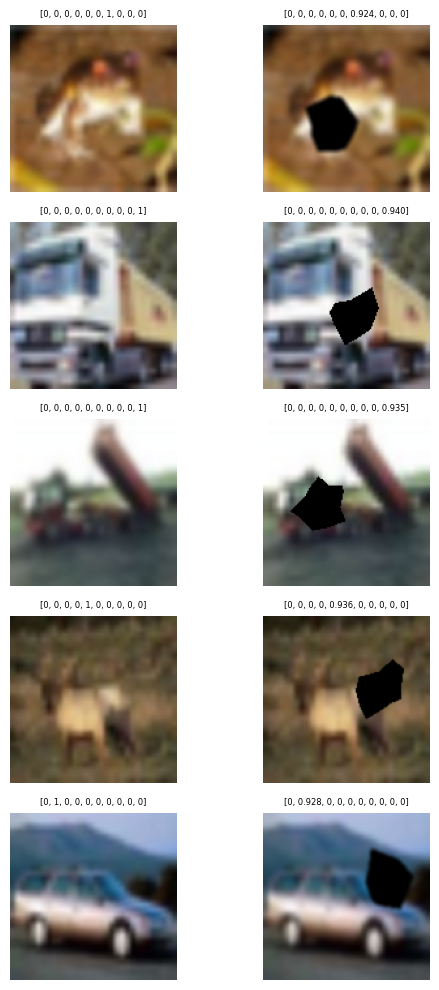

In [28]:
batch_images, batch_labels = next(iter(train_loader))

fig, axes = plt.subplots(5, 2, figsize=(6, 10))
plt.rc('axes', titlesize=6)
for i in range(10):
    row = i //2  
    col = i % 2

    img = batch_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
   
    label_probs = batch_labels[i].numpy().squeeze()  
    formatted_probs = []
    for p in label_probs:
        if 0 < p < 1:
            formatted_probs.append(f"{p:.3f}")
        else:
            formatted_probs.append(f"{int(p)}")
    
    prob_text = "[" + ", ".join(formatted_probs) + "]"
    axes[row, col].imshow(img)
    axes[row, col].set_title(prob_text)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()